# Introduction

This notebook shows a simple image-processing project to find the EURion "star" pattern on banknotes. The aim is to detect small two-ring "star" shapes on Euro notes and check groups of stars using distances and angles.

We use Python (scikit-image, SciPy, NumPy) to:
- make a binary detector image,
- search for matches using template matching (cross-correlation),
- find local peaks and get their positions,
- check groups by comparing distances and angles to the expected pattern.

Figure 0 shows an example image of the EURion pattern used as a detector.

The notebook shows the steps and figures, and explains how we changed the method to reduce false detections.

## Python Imports

In this project the following imports were used:

In [58]:
import skimage.io as io
import skimage.color as cl
import skimage.feature as feat
import  numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import skimage.transform as tf

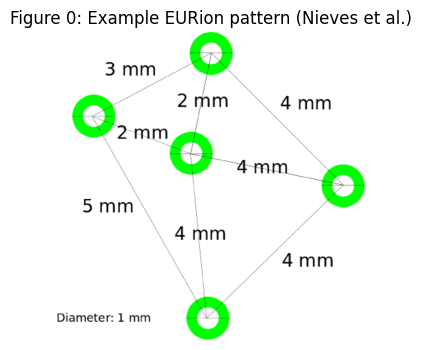

In [59]:
# Show the example EURion pattern used as a detector
rprt_pattern_a_detecter = io.imread(r"5591895-fig-3-source-large.gif")
plt.figure(figsize=(6, 4))
plt.imshow(rprt_pattern_a_detecter[0, :, :, :3])
plt.title('Figure 0: Example EURion pattern (Nieves et al.)')
plt.axis('off')
plt.show()

## Gray EURion star image

The first step is to have a 2D Gray pattern of the EURion constellation 'star', which is a 2D crown or "donut" figure. The RGB is imported from 2010 Nieves et al,  then converted to a grayscale binary image (0 for black and 1 for white)

In [60]:
# Load detector image and convert to grayscale
img = io.imread('EURion_point.png')
gray = cl.rgb2gray(img[:,:,:3])

print(f'Maximum gray value in the image: {max(gray.flatten())}')
print(f'Minimum gray value in the image: {min(gray.flatten())}')

Maximum gray value in the image: 1.0
Minimum gray value in the image: 0.607350980392157


It seems the gray image is made of values between 0.6 and 1. A binary filter with threshold 0.9 is applied to simplify and sharpen the pattern. The image is also truncated to only keep the pattern in the image.

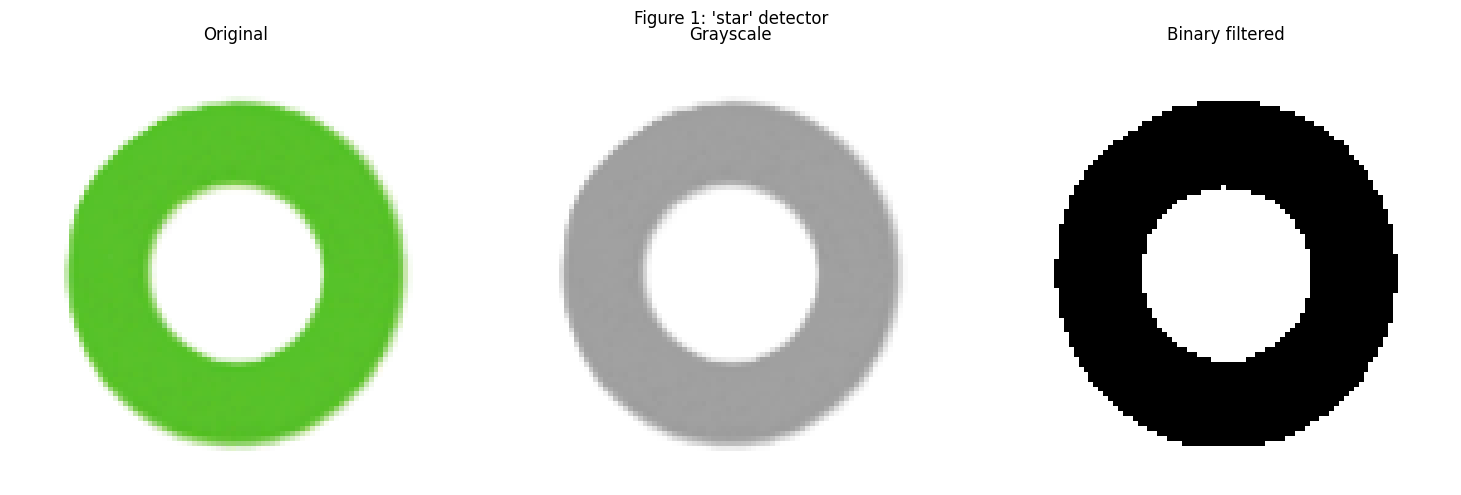

In [61]:
gray_filtered = np.where(gray > 0.9, 1, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Grayscale')
axes[1].axis('off')

axes[2].imshow(gray_filtered, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Binary filtered')
axes[2].axis('off')

fig.suptitle("Figure 1: 'star' detector")
plt.tight_layout()
plt.show()


The chosen 'star' is a bit too low quality for final products, as the discrete projection of the circle is not symetric. Tests will be started with this basis, which will be refined if needed. The pattern in the image is 70 pixels wide, and should be 1mm in real life.

## Proposed methodology

The 'star' pattern (two concentric circles) defined previously will be detected in an image using skimage.feature.match_template. This method uses Fast Normalized Cross-Correlation to find instances of a pattern in another image.

Peaks (local maxima) in match_template's result will be detected with skimage.feature.peak_local_max (with parameters threshold and minimum distance between peaks to define) and stored. Distances between stars will be computed and compared to the pattern defined in 2010 Nieves et al.

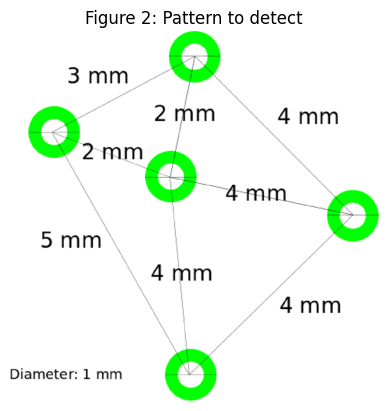

In [62]:
rprt_pattern_a_detecter = io.imread(r"5591895-fig-3-source-large.gif")
plt.imshow(rprt_pattern_a_detecter[0,:,:,:3])
plt.title('Figure 2: Pattern to detect')
plt.axis('off')
plt.show()

In [63]:
#Banknote image to analyze, distance and angle tolerances were adjusted for the 50 euro note

detect_image = io.imread('50euros-verso.jpg')
#detect_image = io.imread('10euros-verso.jpg')
#detect_image = io.imread('20euros-recto.jpg')

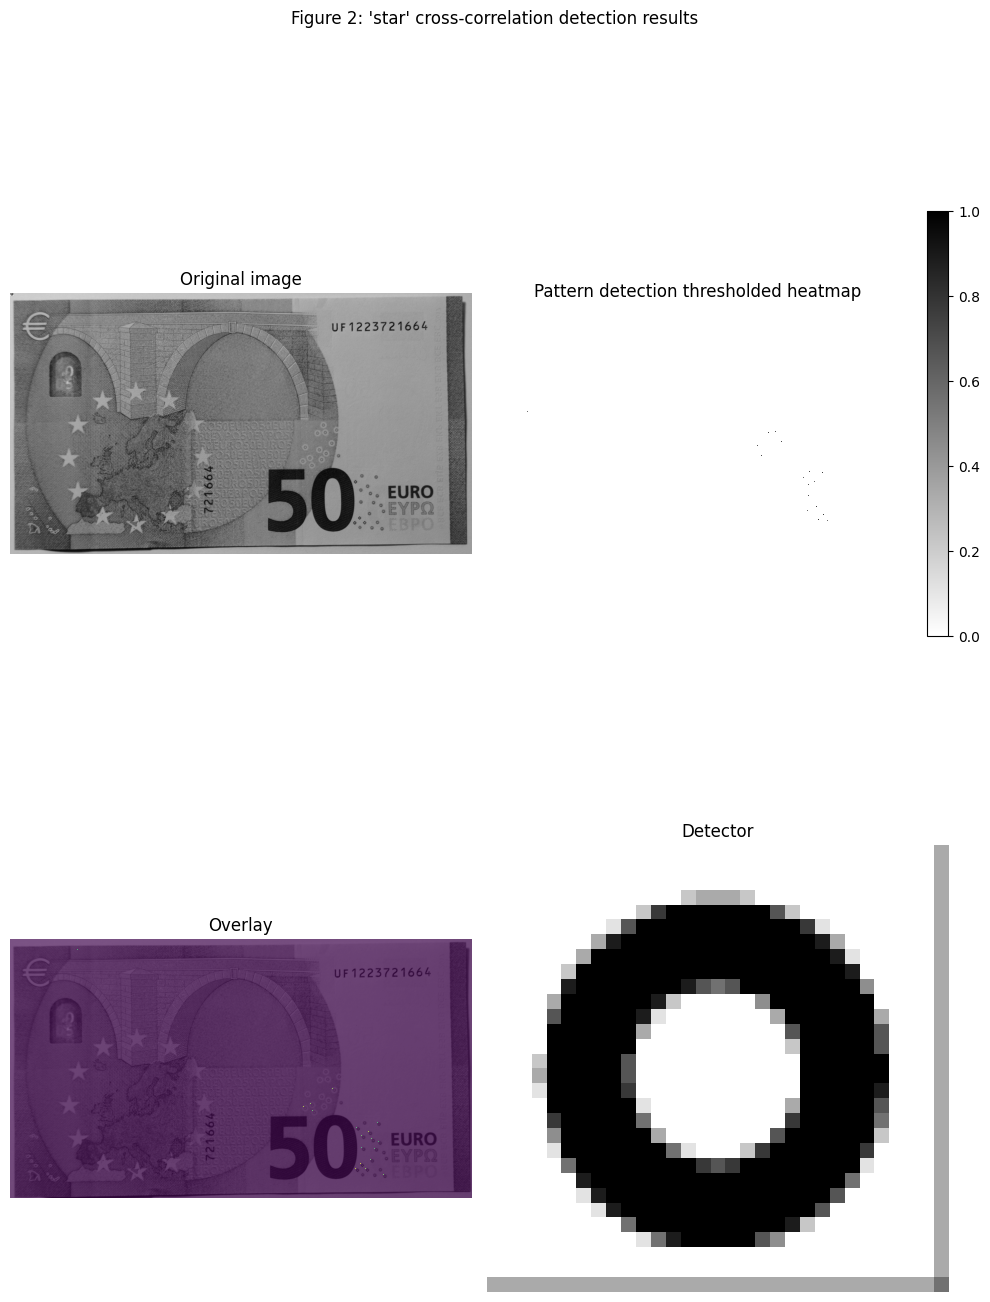

In [64]:
#Import the banknote image and extract the blue channel, prior tests indicated it provided the best contrast

detect_gray = detect_image[:, :, 2] / 255.0

# Adjust detector size
scale_factor = 3
detector = tf.downscale_local_mean(gray_filtered, scale_factor)  


# Use the detector to find patterns in the banknote image with match_template
cross_corr = feat.match_template(detect_gray,detector)

#Threshold the cross-correlation result, to overlay on the image, this method will not be used for actual detection
thr = 0.65 * cross_corr.max()
cc_th = cross_corr.copy()
cc_th[cc_th < thr] = 0

plot1 = detect_gray.copy()
h, w = detector.shape
plot1[:h, :w] = detector


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,15))

#Original image 
ax1.imshow(plot1, cmap='gray', vmin=0, vmax=1)
ax1.set_title('Original image')
ax1.axis('off')

# Pattern detection thresholded heatmap
im = ax2.imshow(cc_th, cmap='gray_r', vmin=0, vmax=1, interpolation='nearest', origin='upper')
ax2.set_title('Pattern detection thresholded heatmap')
ax2.axis('off')
fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

# Overlay overlay of thresholded detection and original image
ax3.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
ax3.imshow(cc_th, cmap='viridis', alpha=0.6,
           extent=(0, cross_corr.shape[1], cross_corr.shape[0], 0),
           interpolation='nearest', origin='upper')
ax3.set_title('Overlay')
ax3.axis('off')

# Detector
ax4.imshow(detector, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
ax4.set_title('Detector')
ax4.axis('off')

fig.suptitle("Figure 2: 'star' cross-correlation detection results")
plt.tight_layout()
plt.show()

It might not be very visible, but some local maxima were detected using our methodology, close to the known 'star' locations. This validates the first part of our methodology.

## Pattern recognition from maxima positions

The next step in our proposed methodology is to use the detected local maxima positions to compare the distances between 'stars' and compare them to those in Figure 2.

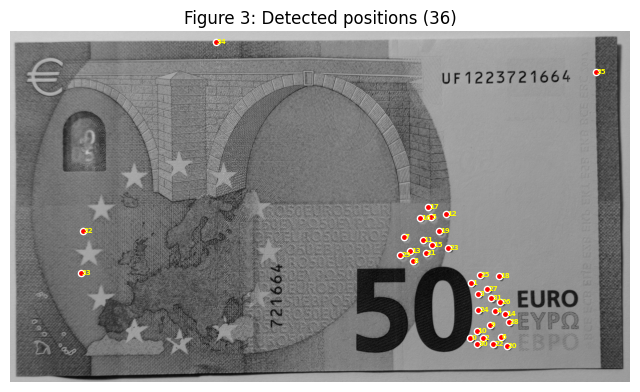

In [65]:
# Find peak positions in the cross-correlation result with peak_local_max
positions = feat.peak_local_max(cross_corr, min_distance=30, threshold_rel=0.7)
positions = np.asarray(positions)

# Plot detected positions on the original image
plt.figure(figsize=(8, 8))
plt.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
if positions.size:
    ys, xs = positions[:, 0], positions[:, 1]
    plt.scatter(xs, ys, c='r', s=20, marker='o', edgecolors='w')
    for i, (y, x) in enumerate(positions):
        plt.text(x + 6, y + 6, str(i), color='yellow', fontsize=5, weight='bold')
plt.title(f'Figure 3: Detected positions ({len(positions)})')
plt.axis('off')
plt.show()

As you can see on the above image, the maxima are correctly detected with 3 false positives and no false negative.

## First prototype: Distances between 'stars'

Our first prototype will measure the distance between stars and try to find a group with two stars similarly distanced from a center star and two other stars twice as far, according to 2010 Nieves et al.

1
1
1
Number of groups found: 3


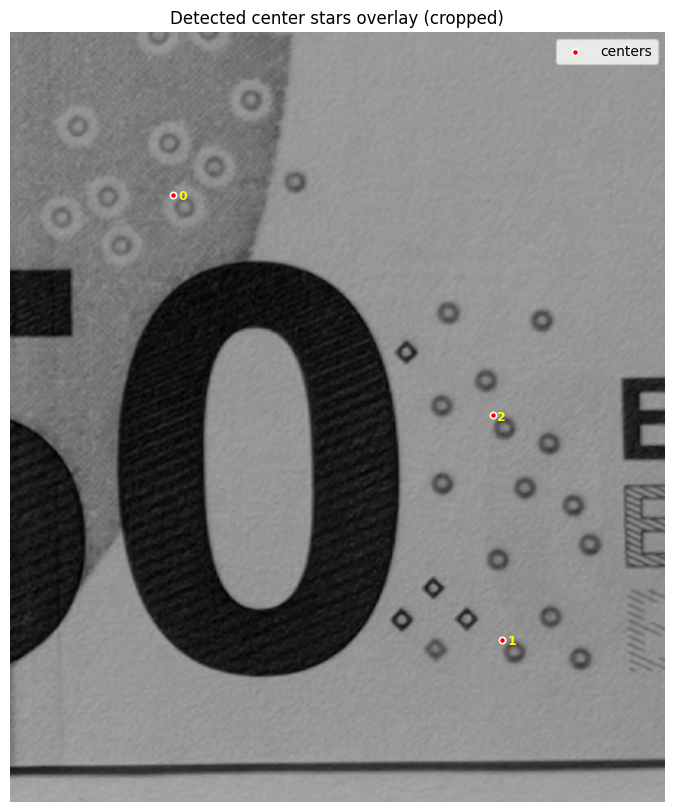

In [66]:
numb_of_dist = 5 # Number of distances to analyze, to reduce computation time
good_enough_dist = 13 # Pixel distance tolerance
groupes_a_further = []
all_distances = []
pr = False
centers = []
for star in positions:
    dist = []

    #Compute distances from the current star to all others
    for star_2 in positions:
        dist.append((np.linalg.norm(star - star_2)))
        all_distances.append((np.linalg.norm(star - star_2)))
    dist_sorted = np.sort(dist)
    if pr:
        print(dist_sorted[1:1+numb_of_dist])
        pr = False

    #Analyze distance groups

    #Starting with the smallest distance (dist_sorted[0] would be the zero distance to itself)
    d_n = dist_sorted[1]
    group_1 = []
    group_2 = []
    for d in dist_sorted[2:2+numb_of_dist]:

        #Add distances to groups based on closeness to d_n or 2*d_n
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 2 * d_n) <= good_enough_dist:
            group_2.append(d)

    #Check if both groups have more than one member and store the corresponding stars' coordinates if so     
    if len(group_1) > 1 and len(group_2) > 1:
        groupe_detoiles = []
        for d in group_1:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        for d in group_2:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        print(1)
        groupes_a_further.append(groupe_detoiles)
        centers.append(star)


    #Repeat for the next smallest distance
    d_n = dist_sorted[2]
    group_1 = []
    group_2 = []
    for d in dist_sorted[3:3+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 2 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        groupe_detoiles = []
        for d in group_1:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        for d in group_2:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        print(1)
        groupes_a_further.append(groupe_detoiles)
        centers.append(star)

    #Repeat for the third smallest distance
    d_n = dist_sorted[3]
    group_1 = []
    group_2 = []
    for d in dist_sorted[4:4+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 2 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        groupe_detoiles = []
        for d in group_1:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        for d in group_2:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        print(1)
        groupes_a_further.append(groupe_detoiles)
        centers.append(star)

print(f'Number of groups found: {len(groupes_a_further)}')


fig, ax = plt.subplots(figsize=(10, 10))

# Plot detected centers on cropped original image
if centers:
    centers_arr = np.asarray(centers)
    cy = centers_arr[:, 0]
    cx = centers_arr[:, 1]

    margin = 200
    ymin = max(int(np.min(cy)) - margin, 0)
    ymax = min(int(np.max(cy)) + margin, detect_gray.shape[0])
    xmin = max(int(np.min(cx)) - margin, 0)
    xmax = min(int(np.max(cx)) + margin, detect_gray.shape[1])

    cropped_img = detect_gray[ymin:ymax, xmin:xmax]
    ax.imshow(cropped_img, cmap='gray', vmin=0, vmax=1)

    # Adjust coordinates to the cropped image
    cx_adj = cx - xmin
    cy_adj = cy - ymin

    ax.scatter(cx_adj, cy_adj, c='red', s=20, edgecolors='white', linewidths=1.2, marker='o', label='centers')

    for i, (x, y) in enumerate(zip(cx_adj, cy_adj)):
        ax.text(x + 6, y + 6, str(i), color='yellow', fontsize=9, weight='bold')

    ax.set_title('Detected center stars overlay (cropped)')
    ax.axis('off')
    ax.legend(loc='upper right')
else:
    ax.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Figure 4: Detected center stars overlay')
    ax.axis('off')

plt.show()


The code found 3 constellations, with only the last one (marked 2 on the graph) being a possible real one, modifying the threshold yields no better results. Multiple real ones were missed even though their stars were detected correctly in the previous steps. This could be due to multiple factors, the most obvious that we thought of besides an error in the code being a small error in the maxima detection, moving the stars from their real positions. 

The next step is to review the detection process, to catch any flaws, for that, we print it again but cropped around the stars this time.

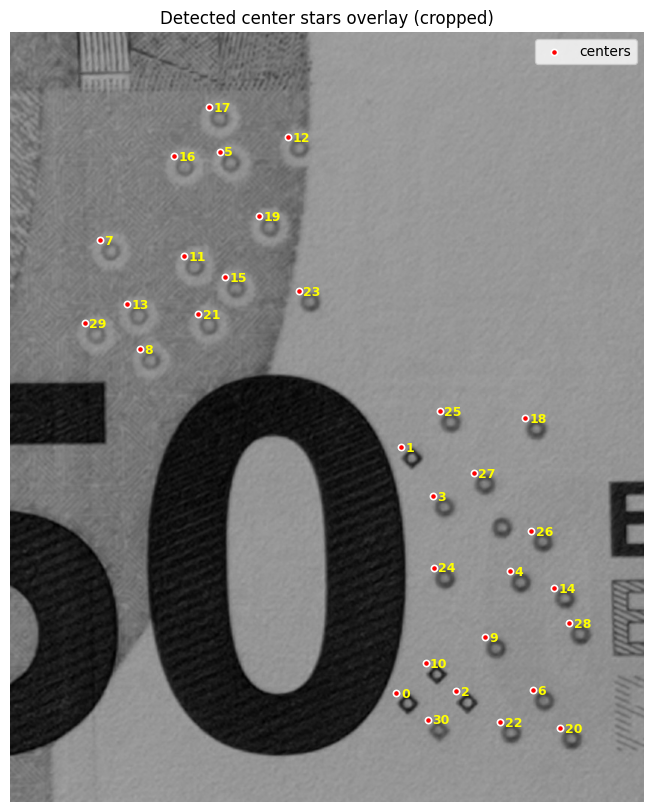

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))

# If we have centers, crop the image around them and display
if centers:
    centers_arr = np.asarray(positions[0:31]) # Limit to the first 31 positions to remove the false positives, as they are at higher indices.
    cy = centers_arr[:, 0]
    cx = centers_arr[:, 1]

    margin = 100
    ymin = max(int(np.min(cy)) - margin, 0)
    ymax = min(int(np.max(cy)) + margin, detect_gray.shape[0])
    xmin = max(int(np.min(cx)) - margin, 0)
    xmax = min(int(np.max(cx)) + margin, detect_gray.shape[1])

    cropped_img = detect_gray[ymin:ymax, xmin:xmax]
    ax.imshow(cropped_img, cmap='gray', vmin=0, vmax=1)

    # Adjust centers coordinates to the cropped image coordinates
    cx_adj = cx - xmin
    cy_adj = cy - ymin

    ax.scatter(cx_adj, cy_adj, c='red', s=20, edgecolors='white', linewidths=1.2, marker='o', label='centers')

    for i, (x, y) in enumerate(zip(cx_adj, cy_adj)):
        ax.text(x + 6, y + 6, str(i), color='yellow', fontsize=9, weight='bold')

    ax.set_title('Detected center stars overlay (cropped)')
else:
    # No centers, show full image for context
    ax.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Figure 5:Detected center stars overlay')
    print("No center stars to plot.")

ax.axis('off')
ax.legend(loc='upper right')
plt.show()


In [68]:
#There appears to be no major problem with the star detection, so we can analyze distances around certain stars to confirm the constellations
print("Around the 8th star")
constellation = [9,12,16,24]
centre = positions[8]
for idx in constellation:
    print(np.linalg.norm(centre - positions[idx]))
print("Around the 14th star")
constellation = [7,11,10,30]
centre = positions[14]
for idx in constellation:
    print(np.linalg.norm(centre - positions[idx]))
print("Around the 27th star")
constellation = [4,18,29,23]
centre = positions[27]
for idx in constellation:
    print(np.linalg.norm(centre - positions[idx]))
print("Around the 3rd star")
constellation = [6,21,17,28]
centre = positions[3]
for idx in constellation:
    print(np.linalg.norm(centre - positions[idx]))
print("Around the 29th star (originally detected)")
constellation = [5,22,23,18]
centre = positions[29]
for idx in constellation:
    print(np.linalg.norm(centre - positions[idx]))

Around the 8th star
602.7976443218736
347.60034522422444
262.8802008520231
491.0040733028597
Around the 14th star
766.8357060022701
666.3640146346439
199.46177578674065
244.72433471152803
Around the 27th star
140.4563989286355
101.17806086301516
559.3612428475896
338.76392960290207
Around the 3rd star
292.4995726492605
398.4482400513271
602.5653491531023
250.4595775769016
Around the 29th star (originally detected)
292.6790050550261
772.3172923093202
290.20337696174386
604.4915218594881


As you can see from these results of known constellations, our basis measurement was incorrect. We were looking for groups with a pair of length n and a pair of length 2n with a very wide error margin, when we should have looked for a pair of length n with either a pair of length n times 10/6 or two separate stars with more precise measurements. This allows us to refine our method and also allows us to tighten the required precision. The group that was also detected around the 29th star also was a wrong one, showing that our previous method only showed false positives.

36
1
1
1
1
1
1
1
1
Number of groups found: 8


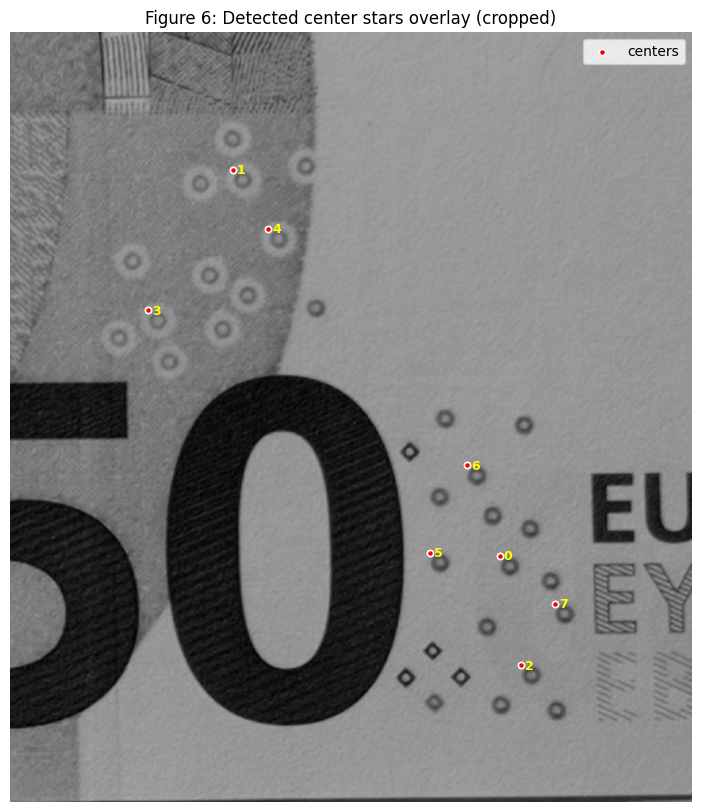

In [69]:
#Repeat the previous distance group analysis with the fixed expected distance ratio and tighter tolerances.

print(len(positions))
numb_of_dist =7
good_enough_dist = 9
groupes_a_further = []
all_distances = []
centers = []
for star in positions:
    dist = []
    for star_2 in positions:
        dist.append((np.linalg.norm(star - star_2)))
        all_distances.append((np.linalg.norm(star - star_2)))
    dist_sorted = np.sort(dist)

    
    d_n = dist_sorted[1]
    group_1 = []
    group_2 = []
    for d in dist_sorted[2:2+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 10/6 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        groupe_detoiles = []
        for d in group_1:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        for d in group_2:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        print(1)
        groupes_a_further.append(groupe_detoiles)
        centers.append(star)
    
    d_n = dist_sorted[2]
    group_1 = []
    group_2 = []
    for d in dist_sorted[3:3+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 10/6 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        groupe_detoiles = []
        for d in group_1:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        for d in group_2:
            groupe_detoiles.append(positions[np.where(dist == d)[0]])
        print(1)
        groupes_a_further.append(groupe_detoiles)
        centers.append(star)

    

print(f'Number of groups found: {len(groupes_a_further)}')


fig, ax = plt.subplots(figsize=(10, 10))
if centers:
    centers_arr = np.asarray(centers)
    cy = centers_arr[:, 0]
    cx = centers_arr[:, 1]

    margin = 200
    ymin = max(int(np.min(cy)) - margin, 0)
    ymax = min(int(np.max(cy)) + margin, detect_gray.shape[0])
    xmin = max(int(np.min(cx)) - margin, 0)
    xmax = min(int(np.max(cx)) + margin, detect_gray.shape[1])

    cropped_img = detect_gray[ymin:ymax, xmin:xmax]
    ax.imshow(cropped_img, cmap='gray', vmin=0, vmax=1)

    cx_adj = cx - xmin
    cy_adj = cy - ymin

    ax.scatter(cx_adj, cy_adj, c='red', s=20, edgecolors='white', linewidths=1.2, marker='o', label='centers')

    for i, (x, y) in enumerate(zip(cx_adj, cy_adj)):
        ax.text(x + 6, y + 6, str(i), color='yellow', fontsize=9, weight='bold')

    ax.set_title('Figure 6: Detected center stars overlay (cropped)')
    ax.axis('off')
    ax.legend(loc='upper right')
else:
    ax.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Figure 6: Detected center stars overlay')
    ax.axis('off')

plt.show()


This second version shows the best results so far, with only 3 false positives (marked 4,5 and 7on the graph) and 0,1,2,3 and 6 being correctly detected. This next version will also include the angle between the stars to ensure they are correctly placed around the center.

[ 55.31726674  55.86591089  80.02499609 140.66271716 144.36758639
 175.28262892 183.04371063]
1
1
1
1
1
Number of groups found: 5


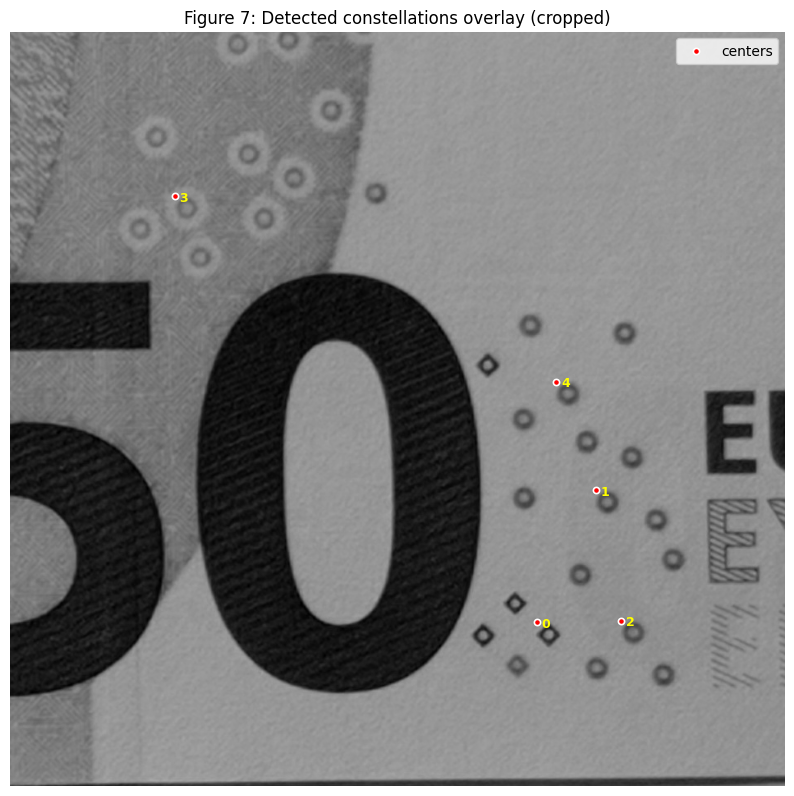

In [70]:
#Refine the previous analysis by adding angle checks to reduce false positives.
numb_of_dist = 7 # Number of distances to analyze
good_enough_dist = 12 #Pixel distance tolerance
good_enough_angle = 15 #Angle tolerance in degrees
#As you can see, adding angle checks allows us to increase the tolerances

groupes_a_further = []
all_distances = []
pr = True
centers = []
for star in positions:

    #Compute distances from the current star to all others
    dist = []
    for star_2 in positions:
        dist.append((np.linalg.norm(star - star_2)))
        all_distances.append((np.linalg.norm(star - star_2)))
    dist_sorted = np.sort(dist)
    if pr:
        print(dist_sorted[1:1+numb_of_dist])
        pr = False

    #Compare distances to the first smallest distance
    d_n = dist_sorted[1]
    group_1 = []
    group_2 = []
    for d in dist_sorted[2:2+numb_of_dist]:
        #Add distances to groups based on closeness to d_n or 100/60*d_n
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 100/60 * d_n) <= good_enough_dist:
            group_2.append(d)
    
    #if both groups have more than one member, check angles between pairs
    if len(group_1) > 1 and len(group_2) > 1:

        #Add star positions to temporary lists for angle calculations
        p1 = []
        for i in range(len(group_1)-1):
            for d in group_1[i+1:]:
                p1.append([positions[np.where(dist == group_1[i])[0]], positions[np.where(dist == d)[0]]])
        p2 = []
        for i in range(len(group_2)-1):
            for d in group_2[i+1:]:
                p2.append([positions[np.where(dist == group_2[i])[0]], positions[np.where(dist == d)[0]]])

        # initialize angle flags
        angle_ok_1 = False
        angle_ok_2 = False

        #Compute angles for all pairs in both groups and compare them to manually defined expected angles
        for pair in p1:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            if angle < 60+good_enough_angle and angle > 60-good_enough_angle:
                angle_ok_1 = True
                break
        for pair in p2:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            if angle < 97+good_enough_angle and angle > 97-good_enough_angle:
                angle_ok_2 = True
                break
        #If both angle checks passed, store the corresponding stars' coordinates
        if angle_ok_1 and angle_ok_2:
            groupe_detoiles = []
            for d in group_1:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            for d in group_2:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            print(1)
            groupes_a_further.append(groupe_detoiles)
            centers.append(star)


    #Repeat for the next smallest distance
    d_n = dist_sorted[2]
    group_1 = []
    group_2 = []
    for d in dist_sorted[3:3+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 100/60 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        p1 = []
        for i in range(len(group_1)-1):
            for d in group_1[i+1:]:
                p1.append([positions[np.where(dist == group_1[i])[0]], positions[np.where(dist == d)[0]]])
        p2 = []
        for i in range(len(group_2)-1):
            for d in group_2[i+1:]:
                p2.append([positions[np.where(dist == group_2[i])[0]], positions[np.where(dist == d)[0]]])

        # initialize angle flags
        angle_ok_1 = False
        angle_ok_2 = False

        for pair in p1:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            if angle < 60+good_enough_angle and angle > 60-good_enough_angle:
                angle_ok_1 = True
                break
        for pair in p2:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            if angle < 97+good_enough_angle and angle > 97-good_enough_angle:
                angle_ok_2 = True
                break
        if angle_ok_1 and angle_ok_2:
            groupe_detoiles = []
            for d in group_1:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            for d in group_2:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            groupes_a_further.append(groupe_detoiles)
            centers.append(star)
            print(2)

    #Repeat for the third smallest distance
    d_n = dist_sorted[3]
    group_1 = []
    group_2 = []
    for d in dist_sorted[4:4+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 100/60 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        p1 = []
        for i in range(len(group_1)-1):
            for d in group_1[i+1:]:
                p1.append([positions[np.where(dist == group_1[i])[0]], positions[np.where(dist == d)[0]]])
        p2 = []
        for i in range(len(group_2)-1):
            for d in group_2[i+1:]:
                p2.append([positions[np.where(dist == group_2[i])[0]], positions[np.where(dist == d)[0]]])

        # initialize angle flags
        angle_ok_1 = False
        angle_ok_2 = False

        for pair in p1:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            if angle < 60+good_enough_angle and angle > 60-good_enough_angle:
                angle_ok_1 = True
                break
        for pair in p2:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            if angle < 97+good_enough_angle and angle > 97-good_enough_angle:
                angle_ok_2 = True
                break
        if angle_ok_1 and angle_ok_2:
            groupe_detoiles = []
            for d in group_1:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            for d in group_2:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            groupes_a_further.append(groupe_detoiles)
            centers.append(star)
            print(3)

print(f'Number of groups found: {len(groupes_a_further)}')



# Plot detected centers on cropped original image
fig, ax = plt.subplots(figsize=(10, 10))
if centers:
    centers_arr = np.asarray(centers)
    cy = centers_arr[:, 0]
    cx = centers_arr[:, 1]
    margin = 200
    ymin = max(int(np.min(cy)) - margin, 0)
    ymax = min(int(np.max(cy)) + margin, detect_gray.shape[0])
    xmin = max(int(np.min(cx)) - margin, 0)
    xmax = min(int(np.max(cx)) + margin, detect_gray.shape[1])

    cropped_img = detect_gray[ymin:ymax, xmin:xmax]
    ax.imshow(cropped_img, cmap='gray', vmin=0, vmax=1)
    cx_adj = cx - xmin
    cy_adj = cy - ymin

    ax.scatter(cx_adj, cy_adj, c='red', s=20, edgecolors='white', linewidths=1.2, marker='o', label='centers')

    for i, (x, y) in enumerate(zip(cx_adj, cy_adj)):
        ax.text(x + 6, y + 6, str(i), color='yellow', fontsize=9, weight='bold')

    ax.set_title('Figure 7: Detected constellations overlay (cropped)')
else:
    ax.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Figure 7: Detected quadrilaterals overlay')

ax.axis('off')

if centers:
    ax.legend(loc='upper right')
    plt.show()
else:
    print("No center stars to plot.")


In this version, 5 constellations were detectected, with only 1 possible false positive (star marked 0). The added angle criterion allowed the first distance criterion to be looser while filtering out more false positives.

## Conclusion

Using a simple method (binary detector, cross-correlation, peaks), we found several EURion-like constellations on a sample 50€ banknote. Changing the expected distance ratio and adding angle checks helped reduce false positives.

The proposed 'star' detection method yields similar results on other euro banknotes (user can modify the banknote right after Figure 2). But as stated previously, the tolerances used here were set for the 50 euro banknote that is set in default right now. Future work include setting a general set of tolerances to support multiple types of banknotes, and setting a decision threshold to provide an answer on wether the image contains a banknote. A threshold of 3 seems correct for the tests done on the 50 euro image that we have here.

The current biggest limitation of our methods is that they work on the specific banknote size that were provided, If our program was included in a scanner as is often the case, this would not be problematic.